In [34]:
from utils import create_lamp_grid, calculate_areas, original_calculate_areas, plot_lamps
import random
import numpy as np
import inspyred
import itertools
import copy
import matplotlib.pyplot as plt

## Test of functions

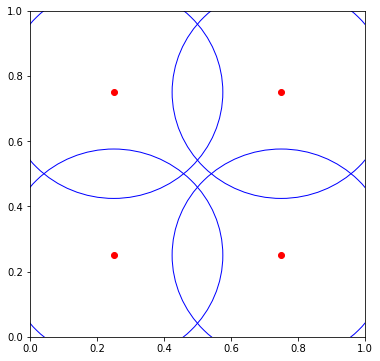

In [2]:
t_grid_size = 3000
t_problem_size = 3
t_lamps = [(0.25, 0.25), (0.75, 0.75), (0.25, 0.75), (0.75, 0.25)]
plot_lamps(t_lamps, t_problem_size, name='test.png')

In [7]:
t_lamp_grid = create_lamp_grid(t_grid_size, t_problem_size)
t_lamp_grid.shape

(1955, 1955)

In [8]:
enlightened_area, overlap_area = calculate_areas(t_lamps, t_grid_size, t_problem_size, t_lamp_grid)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.9872208888888889
Overlap area: 0.34611244444444433


In [9]:
enlightened_area, overlap_area = original_calculate_areas(t_lamps, t_grid_size, t_problem_size)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.9872208888888889
Overlap area: 0.34611244444444433


## Variable Length Genetic Algorithm

In [10]:
# The Evaluator
def evaluator_lamp(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    weight_overlap = args.get('weight_overlap', 1)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, overlap_area = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append((enlightened_area - weight_overlap * overlap_area))
    return fitness

In [11]:
# The Generator
def generator_lamp(random, args):
    problem_size = args.get('problem_size')
    number_lamps = random.randint(problem_size, problem_size*3)
    return [(random.uniform(0, 1), random.uniform(0, 1)) for _ in range(number_lamps)] 

In [12]:
# The Bounder
def bound_lamp(candidate, args):
    for i, c in enumerate(candidate):
        x = max(min(c[0], 1), 0)
        y = max(min(c[1], 1), 0)
        candidate[i] = (x, y)
    return candidate
bound_lamp.lower_bound = itertools.repeat(0)
bound_lamp.upper_bound = itertools.repeat(1)

In [13]:
# The Observer
def observer_lamp(population, num_generations, num_evaluations, args):
    avg_len = np.mean([len(c.candidate) for c in population])
    best = max(population)
    print('{0:6} -- {1} : {2}'.format(num_generations, best.fitness, avg_len))

In [14]:
# Custom mutation operator
def mutate_lamp(random, candidates, args):
    mut_rate = args.setdefault('mutation_rate', 0.1)
    problem_size = args.get('problem_size')
    bounder = args['_ec'].bounder
    for i, cs in enumerate(candidates):
        for j, (c, lo, hi) in enumerate(zip(cs, bounder.lower_bound, bounder.upper_bound)):
            if random.random() < mut_rate:
                xi = random.random()
                if xi < 0.5:
                    # Change the position of the lamp
                    x = c[0] + random.gauss(0, 0.1) * (hi - lo)
                    y = c[1] + random.gauss(0, 0.1) * (hi - lo)
                    candidates[i][j] = (x, y)
                elif xi < 0.75 and len(cs) < 3 * problem_size:
                    # Add a new lamp
                    cs.append((random.uniform(0, 1), random.uniform(0, 1)))
                elif len(cs) > problem_size:
                    # Remove a lamp
                    index = random.randint(0, len(cs)-1)
                    del cs[index]
        candidates[i] = bounder(candidates[i], args)
    return candidates

In [15]:
# Custom crossover operator
def crossover_lamp(random, mom, dad, args):
    crossover_rate = args.setdefault('crossover_rate', 1.0)
    children = []
    
    if random.random() < crossover_rate:
        bro = copy.copy(dad)
        sis = copy.copy(mom)
        length = min(len(mom), len(dad))
        index = random.randint(0, length-1)
        child1 = bro[:index] + sis[index:]
        child2 = sis[:index] + bro[index:]
        children.append(child1)
        children.append(child2)
    else:
        children.append(mom)
        children.append(dad)
    return children

In [16]:
def my_crossover(random, candidates, args):
    if len(candidates) % 2 == 1:
        candidates = candidates[:-1]
    moms = candidates[::2]
    dads = candidates[1::2]
    children = []
    for i, (mom, dad) in enumerate(zip(moms, dads)):
        crossover_lamp.index = i
        offspring = crossover_lamp(random, mom, dad, args)
        for o in offspring:
            children.append(o)
    return children

In [17]:
rand = random.Random()
rand.seed(39)
my_ec = inspyred.ec.EvolutionaryComputation(rand)
#my_ec.selector = inspyred.ec.selectors.tournament_selection
my_ec.variator = [my_crossover, 
                  mutate_lamp]
my_ec.replacer = inspyred.ec.replacers.plus_replacement
my_ec.observer = observer_lamp
my_ec.terminator = [inspyred.ec.terminators.evaluation_termination
                    ,inspyred.ec.terminators.average_fitness_termination]

In [22]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [23]:
final_pop = my_ec.evolve(generator = generator_lamp,
                         evaluator = evaluator_lamp,
                         pop_size = 100,
                         bounder = bound_lamp,
                         max_evaluations = 5000,
                         num_selected = 50,
                         crossover_rate = 1,
                         mutation_rate = 0.5,
                         # Custom args
                         problem_size = problem_size,
                         grid_size = grid_size,
                         lamp_grid = lamp_grid,
                         weight_overlap = 1)
print('Terminated due to {0}.'.format(my_ec.termination_cause))
final_pop.sort(reverse=True)
print(final_pop[0])

     0 -- 0.38294133333333313 : 9.74
     1 -- 0.4099626666666665 : 7.01
     2 -- 0.4099626666666665 : 6.06
     3 -- 0.4648311111111112 : 5.6
     4 -- 0.4648311111111112 : 5.39
     5 -- 0.564432888888889 : 5.36
     6 -- 0.5701733333333334 : 5.31
     7 -- 0.5701733333333334 : 5.32
     8 -- 0.5701733333333334 : 5.26
     9 -- 0.6449582222222223 : 5.19
    10 -- 0.6449582222222223 : 5.15
    11 -- 0.6449582222222223 : 5.08
    12 -- 0.6487413333333334 : 5.06
    13 -- 0.6487413333333334 : 5.06
    14 -- 0.6487413333333334 : 5.07
    15 -- 0.6487413333333334 : 5.07
    16 -- 0.6487413333333334 : 5.07
    17 -- 0.6487413333333334 : 5.05
    18 -- 0.6525022222222223 : 5.04
    19 -- 0.6525022222222223 : 5.01
    20 -- 0.6557200000000001 : 5.02
    21 -- 0.6803351111111111 : 5.01
    22 -- 0.6803351111111111 : 5.01
    23 -- 0.6803351111111111 : 5.0
    24 -- 0.680928 : 5.0
    25 -- 0.680928 : 5.0
    26 -- 0.680928 : 5.0
    27 -- 0.680928 : 5.0
    28 -- 0.680928 : 5.0
    29 -- 0.6

In [26]:
enlightened_area, overlap_area = calculate_areas(final_pop[0].candidate, grid_size, problem_size, lamp_grid)
print("Enlightened area:", enlightened_area)
print("Overlap area:", overlap_area)

Enlightened area: 0.8521822222222222
Overlap area: 0.14781777777777783


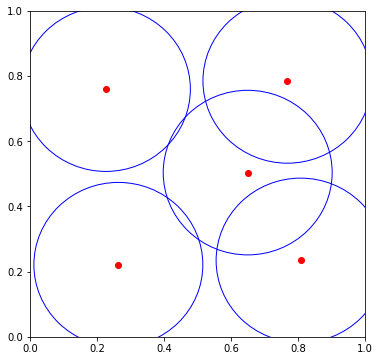

In [27]:
plot_lamps(final_pop[0].candidate, problem_size)

## NSGA-II (Multi-Objective)

In [28]:
# The Evaluator
def evaluator_lamp_multi_objective(candidates, args):
    fitness = []
    problem_size = args.get('problem_size', 4)
    grid_size = args.get('grid_size', 1000)
    lamp_grid = args.get('lamp_grid')
    
    for candidate in candidates:
        enlightened_area, _ = calculate_areas(candidate, grid_size, problem_size, lamp_grid)
        fitness.append(inspyred.ec.emo.Pareto( [-len(candidate), enlightened_area] ))
    return fitness

In [29]:
rand = random.Random()
rand.seed(39)
nsga2 = inspyred.ec.emo.NSGA2(rand)
nsga2.terminator = inspyred.ec.terminators.evaluation_termination
nsga2.variator = [my_crossover, 
                  mutate_lamp]
nsga2.observer = observer_lamp

In [30]:
problem_size = 5
grid_size = 1500
lamp_grid = create_lamp_grid(grid_size, problem_size)

In [31]:
final_pareto_front = nsga2.evolve(generator = generator_lamp,
                                  evaluator = evaluator_lamp_multi_objective,
                                  pop_size = 100,
                                  bounder = bound_lamp,
                                  max_evaluations = 5000,
                                  num_selected = 100,
                                  crossover_rate = 1,
                                  mutation_rate = 0.8,
                                  # Custom args
                                  problem_size = problem_size,
                                  grid_size = grid_size,
                                  lamp_grid = lamp_grid)
print('Terminated due to {0}.'.format(nsga2.termination_cause))

     0 -- [-6, 0.7238364444444444] : 8.92
     1 -- [-11, 0.9480417777777778] : 9.28
     2 -- [-11, 0.9480417777777778] : 9.41
     3 -- [-11, 0.9480417777777778] : 9.63
     4 -- [-11, 0.9480417777777778] : 9.67
     5 -- [-11, 0.9480417777777778] : 9.66
     6 -- [-11, 0.9480417777777778] : 9.67
     7 -- [-7, 0.8904146666666667] : 9.69
     8 -- [-7, 0.8904146666666667] : 9.69
     9 -- [-7, 0.8904146666666667] : 9.68
    10 -- [-7, 0.8904146666666667] : 9.55
    11 -- [-7, 0.8904146666666667] : 9.65
    12 -- [-7, 0.8904146666666667] : 9.69
    13 -- [-7, 0.8904146666666667] : 9.73
    14 -- [-7, 0.8904146666666667] : 9.69
    15 -- [-6, 0.8646773333333333] : 9.73
    16 -- [-6, 0.8646773333333333] : 9.69
    17 -- [-6, 0.8646773333333333] : 9.72
    18 -- [-6, 0.8646773333333333] : 9.72
    19 -- [-6, 0.8646773333333333] : 9.72
    20 -- [-6, 0.8646773333333333] : 9.74
    21 -- [-6, 0.8646773333333333] : 9.75
    22 -- [-6, 0.8646773333333333] : 9.76
    23 -- [-6, 0.86467733333

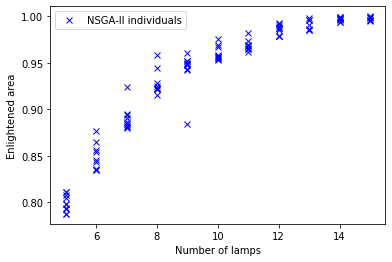

In [37]:
x_nsga2 = [ -individual.fitness[0] for individual in final_pareto_front ]
y_nsga2 = [ individual.fitness[1] for individual in final_pareto_front ]
plt.plot(x_nsga2, y_nsga2, 'bx', label="NSGA-II individuals")
plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

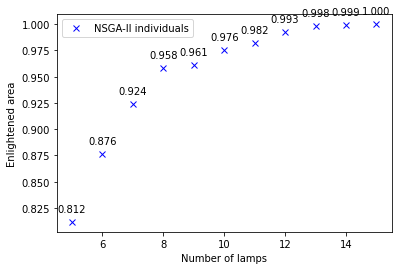

In [38]:
# Select the best individual for each number of lamps
D = {}
for f in final_pareto_front:
    N = len(f.candidate) 
    if N in D:
        if D[N].fitness[1] < f.fitness[1]:
            D[N] = f
    else:
        D[N] = f
x_best = [ -individual.fitness[0] for individual in D.values() ]
y_best = [ individual.fitness[1] for individual in D.values() ]
plt.plot(x_best, y_best, 'bx', label="NSGA-II individuals")
for x, y in zip(x_best, y_best):
    plt.annotate(f'{y:.3f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel("Number of lamps")
plt.ylabel("Enlightened area")
plt.legend(loc="best")

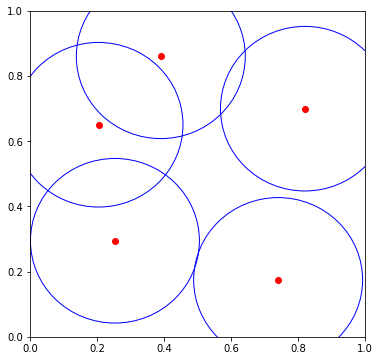

In [39]:
plot_lamps(D[5].candidate, problem_size)

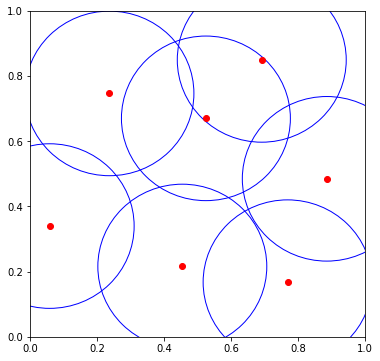

In [41]:
plot_lamps(D[7].candidate, problem_size)